# Result Plots
The code for all of the plots in the results section.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import pickle

%matplotlib inline

## Definitions & Functions from Model Training
Contains all of the necessary functions from the Model Training notebook.

In [ ]:
class MDLayer(nn.Module):
    def __init__(self, input_size, K=5):
        super(MDLayer, self).__init__()
        
        # Mixture probabilities for K Normals
        self.linear_pi = nn.Linear(input_size, K)
        # Means and variances of Normal densities
        self.linear_mu = nn.Linear(input_size, K)
        self.linear_var = nn.Linear(input_size, K)
        
        # Initialize the intercept for the means to be evenly spaced between -5 and 5
        self.linear_mu.bias.data.copy_(torch.linspace(-5, 5, K, dtype=torch.float32))
        # Initialize the intercept for the variances to be -0.5 for all mixtures.
        self.linear_var.bias.data.fill_(-0.5)
        
    def forward(self, x):
        logits_pi = self.linear_pi(x)
        mu = self.linear_mu(x)
        # NOTE: Working with log-variance, so keep it between ~0.1 and ~7.4
        log_var = torch.clamp(self.linear_var(x), min=-2.0, max=2.0)
        return logits_pi, mu, log_var

class MDRNN(nn.Module):
    def __init__(self, h_in_dim, e_in_dim, hidden_size=100, K=5):
        super(MDRNN, self).__init__()
        # History transformation layers
        self.history_transform = nn.Sequential(
            nn.Linear(h_in_dim, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, hidden_size),
            nn.Tanh()
        )
        
        # Mixture density layers
        self.mdn_net = nn.Sequential(
            nn.Linear(hidden_size, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 50),
            nn.Tanh(),
            MDLayer(input_size=50, K=K)
        )
        
        # Layers to transform further to get them ready for auxiliary output calculation
        self.aux_z = nn.Sequential(
            nn.Linear(hidden_size, 100),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size, 50),
            nn.Tanh(),
        )
        
        # Auxiliary output 1: Game outcome (Home Loss, Tie, Home Win)
        self.aux_o = nn.Linear(50, 3)
        
        # Auxiliary output 2: Current score (Continuous)
        self.aux_s_t = nn.Linear(50, 1)
        
        # Recurrent layer
        self.gru = nn.GRU(input_size=e_in_dim,
                          hidden_size=hidden_size,
                          num_layers=1,
                          batch_first=True)
        
    def apply_aux(self, x):
        # Apply the initial auxiliary transformation
        z = self.aux_z(x)
        # Predict the outcome probabilities of the game
        o_logits = self.aux_o(z)
        # And the current score
        s_t = self.aux_s_t(z).squeeze(-1)
        # Return both the outcome probabilities and score
        return o_logits, s_t
    
    def process_history(self, h):
        # Transform the history
        h_features = self.history_transform(h)
        # Estimate the mixture density parameters
        h_out = self.mdn_net(h_features)
        # And the auxiliary outputs for the history
        h_aux = self.apply_aux(h_features)
        # Return all three of those
        return h_out, h_features, h_aux
        
    def forward(self, h, t, X):
        # First step is to process the history up until this game
        h_out, h_features, h_aux = self.process_history(h)
        
        # The recurrent input is the one-hot encoded event types
        gru_in = X
        # The initial state are the transformed history features
        gru_state_0 = h_features.unsqueeze(1)
        
        # Pass the data through the GRU layer
        gru_out, gru_state_n = self.gru(gru_in, gru_state_0)
        
        # Estimate the mixture density parameters
        e_out = self.mdn_net(gru_out)
        # And the auxiliary outputs
        e_aux = self.apply_aux(gru_out)

        # Return the initial and post-GRU mixture density parameters, and auxiliary outputs
        return h_out, e_out, h_aux, e_aux

# Helper function to calculate the log-likelihood of a Normal
def normal_log_pdf(mu, log_var, score):
    log_C = -0.5 * (np.log(2.0 * np.pi) + log_var)
    
    shape = [score.size(0)] + [1] * max(mu.ndim - 2, 0) + [1]
    score_view = score.view(*shape)
    return log_C - 0.5 * ((mu - score_view) ** 2 / torch.exp(log_var))

# Helper function to calculate the log-likelihood of the full mixture density model
def mdn_log_likelihood(out, score):
    logits_pi, mu, log_var = out
    log_normal = normal_log_pdf(mu, log_var, score)
    
    log_pi_norm = torch.logsumexp(logits_pi, dim=-1, keepdim=True)
    log_pi = logits_pi - log_pi_norm
    
    log_v = log_pi + log_normal
    log_ll = torch.logsumexp(log_v, dim=-1)
    return log_ll

## Load In All The Files
These files have been saved outside the two notebooks presented here.

### Data

In [ ]:
# Number of event types
with open(os.path.join(data_path, 'NUM_EVENT_TYPES.pickle'), 'rb') as f:
  NUM_EVENT_TYPES = pickle.load(f)

# The event type <-> ID encoding dictionary
with open(os.path.join(data_path, 'EVENT_TYPE_DICT.pickle'), 'rb') as f:
  EVENT_TYPE_DICT = pickle.load(f)

# Number of history measures
with open(os.path.join(data_path, 'HIST_DIM.pickle'), 'rb') as f:
  HIST_DIM = pickle.load(f)

# Training data
with open(os.path.join(data_path, 'train_ds.pickle'), 'rb') as f:
  train_ds = pickle.load(f)

# And test data
with open(os.path.join(data_path, 'test_ds.pickle'), 'rb') as f:
  test_ds = pickle.load(f)

### Model

#### Regular
The regular model, simply means, the model trained on non-augmented data.

In [ ]:
# Instantiate the MD-RNN with 7 Normals
mdrnn_reg = MDRNN(h_in_dim=HIST_DIM, e_in_dim=NUM_EVENT_TYPES, K=7)
# Load in the pre-trained neural network
checkpoint_reg = torch.load(os.path.join(model_path,'mdrnn_reg.pt'))
mdrnn_reg.load_state_dict(checkpoint_reg['state_dict'])

MDRNN(
  (history_transform): Sequential(
    (0): Linear(in_features=10, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): Tanh()
  )
  (mdn_net): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): Tanh()
    (4): MDLayer(
      (linear_pi): Linear(in_features=50, out_features=7, bias=True)
      (linear_mu): Linear(in_features=50, out_features=7, bias=True)
      (linear_var): Linear(in_features=50, out_features=7, bias=True)
    )
  )
  (aux_z): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): Tanh()
  )
  (aux_o): Linear(in_features=50, out_features=3, bias=True)
  (aux_s_t): L

#### Augmented
To test whether we can improve predictive capabilities by augmenting our data, we added Gaussian noise to every feature of every data point in the training data and appended it. This procedure is **not** showcased in these two notebooks.

In [ ]:
# Instantiate the MD-RNN with 7 Normals
mdrnn_aug = MDRNN(h_in_dim=HIST_DIM, e_in_dim=NUM_EVENT_TYPES, K=7)
# Load in the pre-trained neural network
checkpoint_aug = torch.load(os.path.join(model_path,'mdrnn_aug.pt'))
mdrnn_aug.load_state_dict(checkpoint_aug)

MDRNN(
  (history_transform): Sequential(
    (0): Linear(in_features=10, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): Tanh()
  )
  (mdn_net): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): Tanh()
    (4): MDLayer(
      (linear_pi): Linear(in_features=50, out_features=7, bias=True)
      (linear_mu): Linear(in_features=50, out_features=7, bias=True)
      (linear_var): Linear(in_features=50, out_features=7, bias=True)
    )
  )
  (aux_z): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): Tanh()
  )
  (aux_o): Linear(in_features=50, out_features=3, bias=True)
  (aux_s_t): L

## Create Plots

In [ ]:
# Some constants used throughout this notebook
# Path to where we want to save the figures
figure_path = 'drive/My Drive/figures/'

# Three selected test games for visualization purposes
win_index = 10 # game 10 in test data is a win
draw_index = 28 # game 28 in test data is a draw
loss_index = 5 # game 5 in test data is a loss

### Score distribution
Plots the evolution of the probability distribution of the score difference over the duration of a single game.

In [ ]:
def score_dist_plot(test_index, fname, num_splits=5):
  # Read in the test data for a given game index
  data = test_ds[test_index]
  data = tuple(tensor.unsqueeze(0) for tensor in data)

  # Parse out the individual components
  h, t, X, target, score, s_t = data

  # Grab the predictions from the regular
  h_out, e_out, h_aux, e_aux = mdrnn_reg(h, t, X)
  # And augmented models
  h_out_aug, e_out_aug, h_aux_aug, e_aux_aug = mdrnn_aug(h, t, X)

  # Get the total number of time points
  T = t.size(1)
  # And evenly split them up
  tid_grid = list(range(0, T, T // num_splits))
  # Make sure we always include the last period
  if tid_grid[-1] != T - 1:
      tid_grid[-1] = T - 1

  # Create a 1-column plot object
  fig, axes = plt.subplots(nrows=len(tid_grid), ncols=1, figsize=(5, 15))
  legend_flag = True
  # For each time point
  for i, tid in enumerate(tid_grid):
      # Extract the mixture density parameters for the regular and augmented models
      logits_pi, mu, log_var = (e_out[0][0][tid], e_out[1][0][tid], e_out[2][0][tid])
      logits_pi_aug, mu_aug, log_var_aug = (e_out_aug[0][0][tid], 
                                            e_out_aug[1][0][tid], 
                                            e_out_aug[2][0][tid])
      mixture = logits_pi, mu, log_var
      mixture_aug = logits_pi_aug, mu_aug, log_var_aug

      # Fix the x-axis of possible score differences
      s_grid = np.linspace(-8, 8, 150)
      # And calculate the log-likelihood of each of them for both the regular and augmented model
      log_ll_grid = []
      log_ll_grid_aug = []
      for s in s_grid:
          s = torch.tensor([s]).cuda()
          log_ll_grid.append(mdn_log_likelihood(mixture, s).view(-1).item())
          log_ll_grid_aug.append(mdn_log_likelihood(mixture_aug, s).view(-1).item())
      
      # For the current graph
      plt.sca(axes[i])
      # Plot the pdf [exp(log-likelihood)] for both models
      plt.plot(s_grid, np.exp(log_ll_grid), linewidth=2, color='b', label='Regular')
      plt.plot(s_grid, np.exp(log_ll_grid_aug), linewidth=2, color='r', label='Augmented')
      # And only add the legend once
      if legend_flag:
        plt.legend()
        legend_flag = False
      # Add a tie indicator line
      plt.axvline(score.item(), c='g', linestyle='-', linewidth=2)
      # And the actual score at the given time
      plt.axvline(s_t[0][tid].item(), c='k', linestyle='--')
      # Add a title and grid for visual purposes
      plt.title('Time: %.2f' % t[0][tid].item())
      plt.grid()

  # Some minor visual adjustments
  plt.xlabel('Score difference')
  plt.tight_layout()
  fig.subplots_adjust(top=0.94)
  
  # And save the figure
  plt.savefig(os.path.join(figure_path, 'score_dist_%s.pdf' % (fname)))

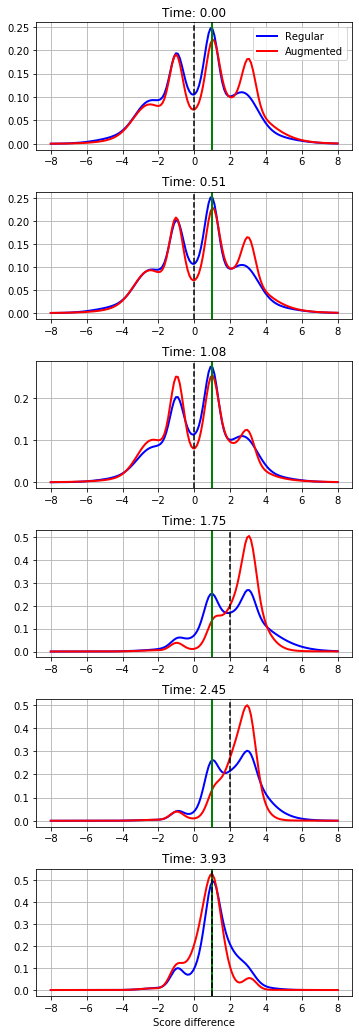

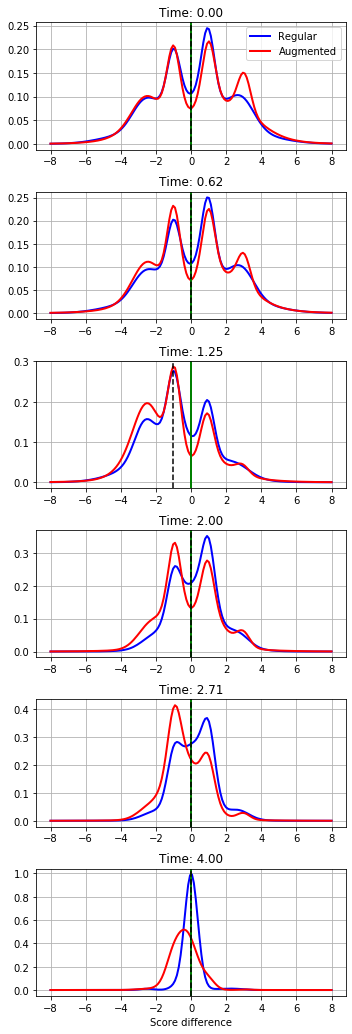

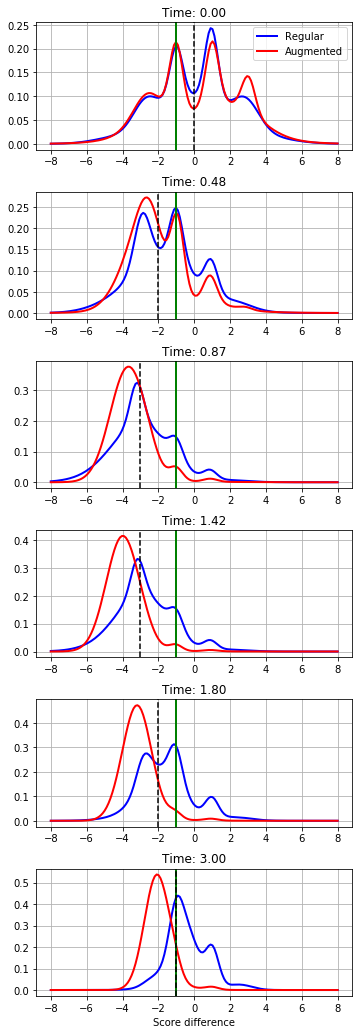

In [ ]:
# Some examples
score_dist_plot(win_index,'win')
score_dist_plot(draw_index,'draw')
score_dist_plot(loss_index,'lose', num_splits=6)

### Confidence Curve
Plots the probability of the true game outcome (confidence) over the period of a game.

In [ ]:
def conf_curve_data(test_index, num_splits=100):
  # Read in the test data for a given game index
  data = test_ds[test_index]
  data = tuple(tensor.unsqueeze(0) for tensor in data)

  # Parse out the individual components
  h, t, X, target, score, s_t = data

  # Grab the predictions from the regular
  h_out, e_out, h_aux, e_aux = mdrnn_reg(h, t, X)
  # And augmented models
  h_out_aug, e_out_aug, h_aux_aug, e_aux_aug = mdrnn_aug(h, t, X)

  # Get the total number of time points
  T = t.size(1)
  # And evenly split them up
  tid_grid = list(range(0, T, T // num_splits))
  # Make sure we always include the last period
  if tid_grid[-1] != T - 1:
      tid_grid[-1] = T - 1

  # Get the final game score
  s = torch.tensor([score.item()])

  # Initialize the log confidence arrays
  log_conf_grid = []
  log_conf_grid_aug = []
  # For each of the time periods
  for i, tid in enumerate(tid_grid):
      # Extract the mixture density parameters for both models
      logits_pi, mu, log_var = (e_out[0][0][tid], e_out[1][0][tid], e_out[2][0][tid])
      mixture = logits_pi, mu, log_var
      logits_pi_aug, mu_aug, log_var_aug = (e_out_aug[0][0][tid], e_out_aug[1][0][tid], e_out_aug[2][0][tid])
      mixture_aug = logits_pi_aug, mu_aug, log_var_aug

      # And append their log-likelihood of the true final game outcome
      log_conf_grid.append(mdn_log_likelihood(mixture,s).view(-1).item())
      log_conf_grid_aug.append(mdn_log_likelihood(mixture_aug,s).view(-1).item())

  # The x-axis are the time periods
  x = [t[0][tid].item() for tid in tid_grid]
  # The y-axis is the probability of the true score at any given time
  y = np.exp(log_conf_grid)
  y_aug = np.exp(log_conf_grid_aug)

  # Return the x-, y-axis for both models, and the true score
  return x,y,y_aug,score.item()

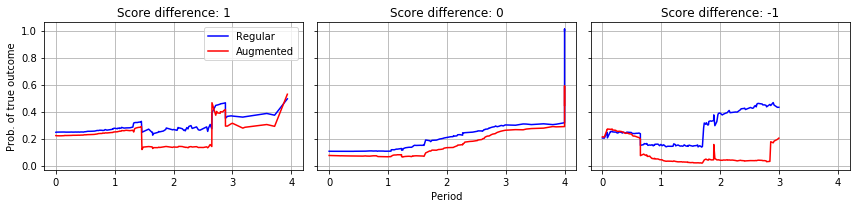

In [ ]:
# Get the x-, y-axis, and final score for the three selected test games
wx,wy,wya,ws = conf_curve_data(win_index)
dx,dy,dya,ds = conf_curve_data(draw_index)
lx,ly,lya,ls = conf_curve_data(lose_index)

# Create a three column plot
xlabel = 'Period'
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 3),
                         sharex=True, sharey=True)

# The first plot is the win, with a score difference of 1
plt.sca(axes[0])
plt.plot(wx,wy, c='b', label='Regular')
plt.plot(wx,wya, c='r', label='Augmented')
plt.grid()
plt.legend()
plt.ylabel('Prob. of true outcome')
plt.title('Score difference: %d' % (ws))

# The second plot is the draw, with a score difference of 0
plt.sca(axes[1])
plt.plot(dx,dy, c='b')
plt.plot(dx,dya, c='r')
plt.grid()
plt.xlabel(xlabel)
plt.title('Score difference: %d' % (ds))

# The third plot is the loss, with a score difference of -1
plt.sca(axes[2])
plt.plot(lx,ly, c='b')
plt.plot(lx,lya, c='r')
plt.grid()
plt.title('Score difference: %d' % (ls))

# Make the plot pretty and save it
plt.tight_layout()
plt.savefig(os.path.join(figure_path, 'conf_curve.pdf'))

### Probability Curve
Plots the probability of the true score difference over the period of a game.

#### Helper Functions
Some helper functions to calculate the necessary probabilities.

In [ ]:
# Helper function to get the log CDF of the mixture density model
def mdn_log_cdf(out,at_):
  # Parse out the mixture density parameters
  logits_pi, mu, log_var = out
  # Initialize Normal distributions with the parameters
  n = torch.distributions.normal.Normal(mu, torch.sqrt(torch.exp(log_var)))
  # And get the log CDF approximations
  log_cdfs = torch.log(n.cdf(at_))

  # Calculate the mixture probabilities
  log_pi_norm = torch.logsumexp(logits_pi, dim=-1, keepdim=True)
  log_pi = logits_pi - log_pi_norm

  # And aggregate them together to get the log CDF of the whole mixture
  log_v = log_pi + log_cdfs
  log_cdf = torch.logsumexp(log_v, dim=-1)
  return log_cdf

# Choose a cutoff after which we consider a game a win
CUTOFF = 0.5
# Helper function to get win probability
def prob_win(out,cutoff=CUTOFF):
  # Get the log CDF
  log_cdf = mdn_log_cdf(out,cutoff).item()
  # And calculate P(X > 0.5) = 1 - Phi(0.5)
  cdf = np.exp(log_cdf)
  p_win = 1 - cdf
  return p_win

# Helper function to get loss probability
def prob_lose(out,cutoff=-1.0 * CUTOFF):
  # Get the log CDF
  log_cdf = mdn_log_cdf(out,cutoff).item()
  # And calculate P(X < -0.5) = Phi(-0.5)
  p_lose = np.exp(log_cdf)
  return p_lose

# Helper function to get draw probability
def prob_draw(out,cutoff=CUTOFF):
  # Get the log CDF of -0.5 and 0.5
  log_cdfA = mdn_log_cdf(out,-1.0 * cutoff).item()
  log_cdfB = mdn_log_cdf(out,cutoff).item()
  # And calculate P(-0.5 <= X <= 0.5) = Phi(0.5) - Phi(-0.5)
  cdfB = np.exp(log_cdfB)
  cdfA = np.exp(log_cdfA)
  p_draw = cdfB - cdfA
  return p_draw

#### Plotting Function
The actual functions to plot the probability curve.

In [ ]:
def pcurve_data(test_index, p_fun, num_splits=100):
  # Read in the test data for a given game index
  data = test_ds[test_index]
  data = tuple(tensor.unsqueeze(0) for tensor in data)

  # Parse out the individual components
  h, t, X, target, score, s_t = data

  # Grab the predictions from the regular
  h_out, e_out, h_aux, e_aux = mdrnn_reg(h, t, X)
  # And augmented models
  h_out_aug, e_out_aug, h_aux_aug, e_aux_aug = mdrnn_aug(h, t, X)

  # Get the total number of time points
  T = t.size(1)
  # And evenly split them up
  tid_grid = list(range(0, T, T // num_splits))
  # Make sure we always include the last period
  if tid_grid[-1] != T - 1:
      tid_grid[-1] = T - 1

  # Get the final game score
  s = torch.tensor([score.item()])

  # Initialize the probability arrays for both the regular and augmented model
  p_grid = []
  p_grid_aug = []
  # For each time period
  for i, tid in enumerate(tid_grid):
      # Extract the mixture density model parameters for both models
      logits_pi, mu, log_var = (e_out[0][0][tid], e_out[1][0][tid], e_out[2][0][tid])
      mixture = logits_pi, mu, log_var
      logits_pi_aug, mu_aug, log_var_aug = (e_out_aug[0][0][tid], 
                                            e_out_aug[1][0][tid], 
                                            e_out_aug[2][0][tid])
      mixture_aug = logits_pi_aug, mu_aug, log_var_aug

      # And append the probabilities of the chosen outcome (win/draw/loss) to the arrays
      p_grid.append(p_fun(mixture))
      p_grid_aug.append(p_fun(mixture_aug))
  
  # Create the x-axis values and return all of it
  x = [t[0][tid].item() for tid in tid_grid]
  return x,p_grid,p_grid_aug,score.item()

In [ ]:
def pcurves(test_index, fname, num_splits=100):
  # Get the x-, y-axis, and final scores for the three possible outcomes
  wx,wy,wya,s = pcurve_data(test_index,prob_win)
  dx,dy,dya,_ = pcurve_data(test_index,prob_draw)
  lx,ly,lya,_ = pcurve_data(test_index,prob_lose)

  # Create a 3 column plot
  fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 3), 
                           sharex=True, sharey=True)

  # The first plot is the win probability
  plt.sca(axes[0])
  plt.plot(wx,wy,c='b', label='Regular')
  plt.plot(wx,wya,c='r', label='Augmented')
  plt.grid()
  plt.legend()
  plt.ylabel('Probability')
  plt.title('Win')

  # The second plot is the draw probability
  plt.sca(axes[1])
  plt.plot(dx,dy,c='b')
  plt.plot(dx,dya,c='r')
  plt.grid()
  plt.xlabel('Period')
  plt.title('Draw')

  # The third plot is the loss probability
  plt.sca(axes[2])
  plt.plot(lx,ly,c='b')
  plt.plot(lx,lya,c='r')
  plt.grid()
  plt.title('Lose')

  # Tweak the title and layout
  plt.suptitle('Score difference: %d' % (s))
  plt.tight_layout()
  fig.subplots_adjust(top=0.80)

  # And save the figure
  plt.savefig(os.path.join(figure_path, 'prob_curve_%s.pdf' % (fname)))

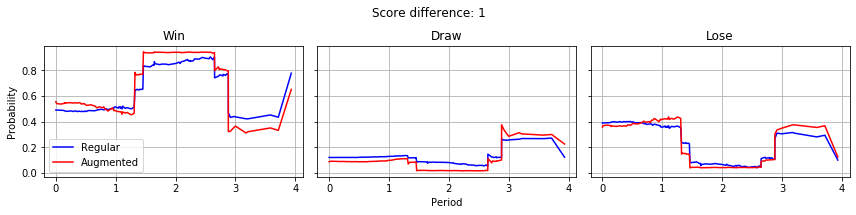

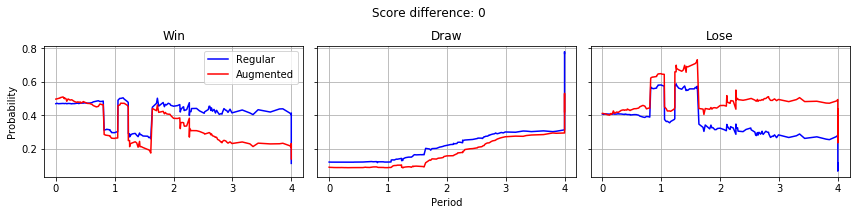

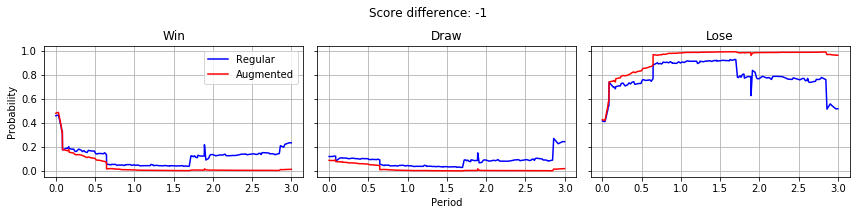

In [ ]:
# Some examples
pcurves(win_index, 'win')
pcurves(draw_index, 'draw')
pcurves(lose_index, 'lose')

### Bar Chart
The average change in probability of an event on the game outcome (win/draw/loss) for a game.

#### Helper Functions
Some helper functions to calculate the necessary probabilities and the changes.

In [ ]:
def id_event(event,home_only=False):
  index = np.argmax(np.abs(event))
  out = index
  if home_only:
    out = index if event[index] > 0 else (-1 * index)
  
  return out

def event_pchange(test_index, event_index, p_fun, mdrnn=mdrnn_reg,absolute=True):
  # Read in the test data for a given game index
  data = test_ds[test_index]
  data = tuple(tensor.unsqueeze(0) for tensor in data)

  # Parse out the individual components
  h, t, X, target, score, s_t = data

  # Grab the predictions from the model
  h_out, e_out, h_aux, e_aux = mdrnn(h, t, X)
  
  # Get the list of all possible event ids
  events = [id_event(e, not absolute) for e in X[0].cpu().numpy()]
  # Get all of the occurrences of the chosen event
  tid_grid = list(np.where(np.array(events) == event_index)[0])

  # Initialize the before and after probabilitites
  p_before = []
  p_after = []
  # For each event
  for i, tid in enumerate(tid_grid):
    # Get the mixture density parameters before and after the event happened
    logits_pi_before, mu_before, log_var_before = (e_out[0][0][tid-1], e_out[1][0][tid-1], e_out[2][0][tid-1])
    logits_pi_after, mu_after, log_var_after = (e_out[0][0][tid], e_out[1][0][tid], e_out[2][0][tid])
    mixture_before = logits_pi_before, mu_before, log_var_before
    mixture_after = logits_pi_after, mu_after, log_var_after

    # And attach their probabilities to the arrays
    p_before.append(p_fun(mixture_before))
    p_after.append(p_fun(mixture_after))

  # And calculate the probability change (absolute or not)
  p_before = np.array(p_before)
  p_after = np.array(p_after)
  changes = np.abs(p_after - p_before) if absolute else p_after - p_before

  return changes

def event_pchange_agg(test_index, event_index, agg_fun, mdrnn, absolute=True):
  # Calculate the change on the win, loss, and draw probabilities for a given event
  changes_win = event_pchange(test_index, event_index, prob_win, mdrnn, absolute)
  changes_lose = event_pchange(test_index, event_index, prob_lose, mdrnn, absolute)
  changes_draw = event_pchange(test_index, event_index, prob_draw, mdrnn, absolute)

  # And aggregate those changes
  change_win = np.nan_to_num(agg_fun(changes_win))
  change_lose = np.nan_to_num(agg_fun(changes_lose))
  change_draw = np.nan_to_num(agg_fun(changes_draw))

  return change_win, change_draw, change_lose

#### Plotting Function
The actual functions to plot the bar plot.

In [ ]:
def event_barplot_data(test_index, mdrnn=mdrnn_reg, agg_fun=np.mean, absolute=False):
  # Read in the test data for a given game index
  data = test_ds[test_index]
  data = tuple(tensor.unsqueeze(0) for tensor in data)

  # Parse out the individual components
  h, t, X, target, score, s_t = data

  # All the event type labels
  labels = ['Faceoff', 'Giveaway', 'Blocked Shot', 'Shot',
            'Hit', 'Goal', 'Penalty', 'Takeaway',
            'Missed Shot', 'Official Challenge']
  # Calculate the probability changes for all the events above
  probs = [event_pchange_agg(test_index, e, agg_fun, mdrnn, absolute) for e in range(1,11)]
  pwin = [p[0] for p in probs]
  pdraw = [p[1] for p in probs]
  plose = [p[2] for p in probs]

  # Set the width of the bars
  width = 0.35 
  # Arrange three bars (win/draw/loss) next to each other for each event
  r1 = np.arange(len(pwin))
  r2 = [x + width for x in r1]
  r3 = [x + width for x in r2]

  # Add the event type labels and y-axis label
  xticks = [r + width for r in range(len(pwin))]
  ylabel = 'Avg. change in prob.' if not absolute else 'Absolute change in prob.'

  # Return all the relevant plot infor
  return r1,r2,r3,pwin,pdraw,plose,width,'white',xticks,labels,ylabel,score.item()

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


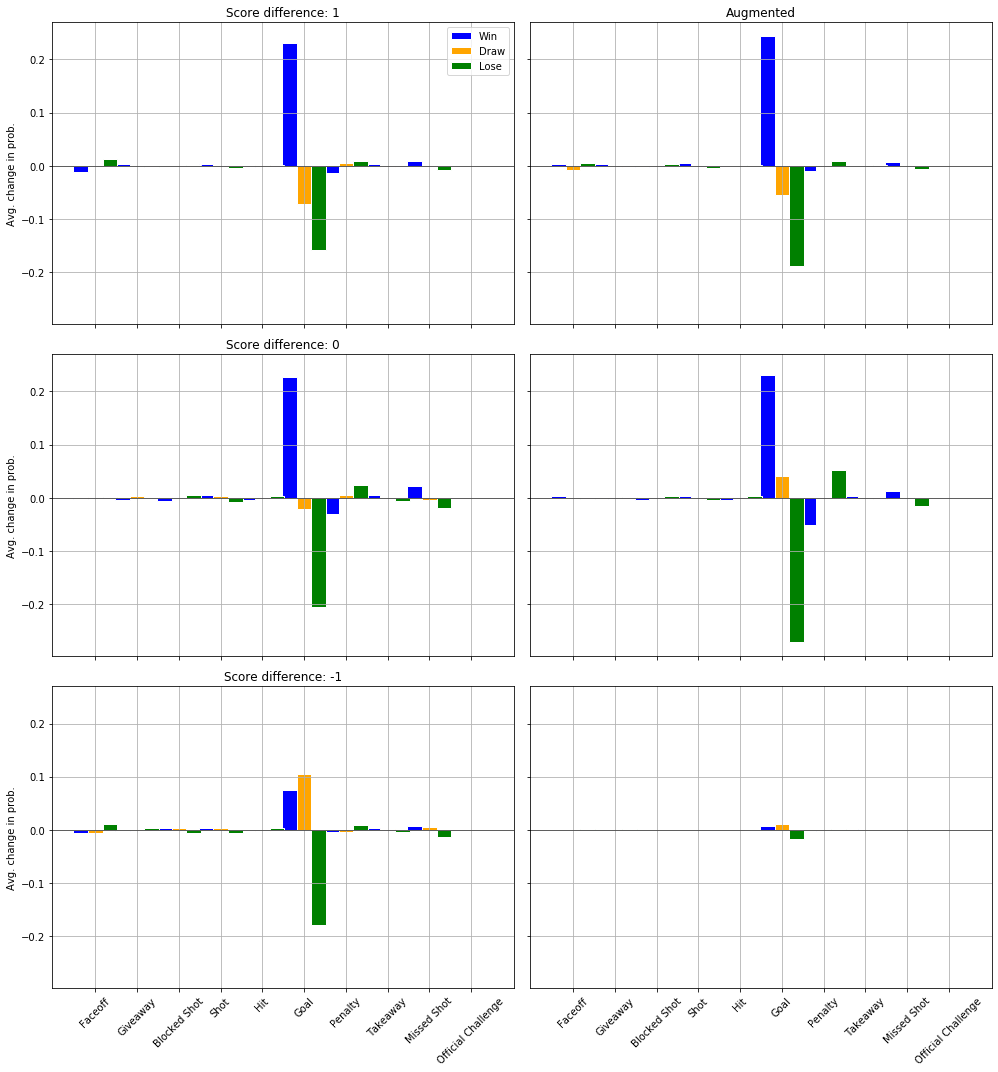

In [ ]:
# Calculate all the event probability change barplot info for the three chosen games for the regular
wx1,dx1,lx1,wy1,dy1,ly1,w,ec,xt1,lab,ylab1,s1 = event_barplot_data(win_index)
wx2,dx2,lx2,wy2,dy2,ly2,_,_,xt2,_,ylab2,s2 = event_barplot_data(draw_index)
wx3,dx3,lx3,wy3,dy3,ly3,_,_,xt3,_,ylab3,s3 = event_barplot_data(lose_index)

# And augmented models
wx4,dx4,lx4,wy4,dy4,ly4,w,ec,xt4,lab,ylab4,s4 = event_barplot_data(win_index, mdrnn=mdrnn_aug)
wx5,dx5,lx5,wy5,dy5,ly5,_,_,xt5,_,ylab5,s5 = event_barplot_data(draw_index, mdrnn=mdrnn_aug)
wx6,dx6,lx6,wy6,dy6,ly6,_,_,xt6,_,ylab6,s6 = event_barplot_data(lose_index, mdrnn=mdrnn_aug)

# Create a 3 [win, draw, loss] x 2 [regular, augmented] plot
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 15),
                         sharex=True, sharey=True)

# Plot 1: Win, Regular
plt.sca(axes[0,0])
plt.bar(wx1,wy1,width=w,edgecolor=ec, label='Win', color='blue')
plt.bar(dx1,dy1,width=w,edgecolor=ec, label='Draw', color='orange')
plt.bar(lx1,ly1,width=w,edgecolor=ec, label='Lose', color='green')
plt.xticks(xt1,lab,rotation=45)
plt.axhline(0, color = 'black', linewidth=0.5)
plt.title('Score difference: %d' % (s1))
plt.ylabel(ylab1)
plt.grid()
plt.legend()

# Plot 2: Draw, Regular
plt.sca(axes[1,0])
plt.bar(wx2,wy2,width=w,edgecolor=ec, label='Win', color='blue')
plt.bar(dx2,dy2,width=w,edgecolor=ec, label='Draw', color='orange')
plt.bar(lx2,ly2,width=w,edgecolor=ec, label='Lose', color='green')
plt.xticks(xt2,lab,rotation=45)
plt.axhline(0, color = 'black', linewidth=0.5)
plt.title('Score difference: %d' % (s2))
plt.ylabel(ylab1)
plt.grid()

# Plot 3: Loss, Regular
plt.sca(axes[2,0])
plt.bar(wx3,wy3,width=w,edgecolor=ec, label='Win', color='blue')
plt.bar(dx3,dy3,width=w,edgecolor=ec, label='Draw', color='orange')
plt.bar(lx3,ly3,width=w,edgecolor=ec, label='Lose', color='green')
plt.xticks(xt3,lab,rotation=45)
plt.axhline(0, color = 'black', linewidth=0.5)
plt.title('Score difference: %d' % (s3))
plt.ylabel(ylab1)
plt.grid()

# Plot 4: Win, Augmented
plt.sca(axes[0,1])
plt.bar(wx4,wy4,width=w,edgecolor=ec, label='Win', color='blue')
plt.bar(dx4,dy4,width=w,edgecolor=ec, label='Draw', color='orange')
plt.bar(lx4,ly4,width=w,edgecolor=ec, label='Lose', color='green')
plt.xticks(xt1,lab,rotation=45)
plt.axhline(0, color = 'black', linewidth=0.5)
plt.title('Augmented')
plt.grid()

# Plot 5: Draw, Augmented
plt.sca(axes[1,1])
plt.bar(wx5,wy5,width=w,edgecolor=ec, label='Win', color='blue')
plt.bar(dx5,dy5,width=w,edgecolor=ec, label='Draw', color='orange')
plt.bar(lx5,ly5,width=w,edgecolor=ec, label='Lose', color='green')
plt.xticks(xt2,lab,rotation=45)
plt.axhline(0, color = 'black', linewidth=0.5)
plt.grid()

# Plot 6: Loss, Augmented
plt.sca(axes[2,1])
plt.bar(wx6,wy6,width=w,edgecolor=ec, label='Win', color='blue')
plt.bar(dx6,dy6,width=w,edgecolor=ec, label='Draw', color='orange')
plt.bar(lx6,ly6,width=w,edgecolor=ec, label='Lose', color='green')
plt.xticks(xt3,lab,rotation=45)
plt.axhline(0, color = 'black', linewidth=0.5)
plt.grid()

# Make it pretty
plt.tight_layout()

# And save the figure
plt.savefig(os.path.join(figure_path, 'event_bar_full.pdf'))